# Bayesian Linear Regression part 2: demo data

![sigmoid function with x's marking samples](images/2018-01-08-sigmoid.png)

When I was first looking at machine learning demo code, there was sometimes a scary amount of code for the setup.
I learned that a lot of this is to generate observations.
After doing a few on my own, it's a little less scary! Here are a few examples.

## Why do this?

In [**Part 1**]({% post_url 2018-01-03-bayesian-linreg %}) of this series, I showed how
to sample fits from a prior on the weights.
Later I want to show how to combine this with observations to get a posterior on the weights, which I'll then use to make predictions. But to do that, I need observations.


One way to do this is to start with the underlying function, find the function value at some inputs, add some noise (usually Gaussian), and call these our observations. Then apply the machine learning techniques to those observations, and compare its guess of the function to the real function.

$$y = f(\textbf x) + v$$


(I use bold, like \\(\textbf x\\), to indicate it's a vector. So \\( f \\) takes a vector and returns a scalar.)
This matches super well with how textbooks and courses start talking about machine learning. (Also with experiments and statistics!) They start by assuming that observations are a combination of an underlying function and noise, and the goal is to find the underlying function.


### Other ways

tbh, I don't know all of the other ways to do this!

I know one way to get sample data would be to use a real dataset, like one from [scikit-learn](http://scikit-learn.org/stable/datasets/index.html) or [Kaggle](http://kaggle.com). I imagine these could make it a little harder to see what a machine learning technique does.

## Code

I'm going to use numpy and matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# helper functions you can skip over :D
SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

### Choose x values

I'll start by choosing some input values between -1 and 1.

I could choose equally-spaced values with `np.linspace`:

In [2]:
np.linspace(-1, 1, 11)

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

    array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

I could also select random, uniformly distributed points using `np.random.rand`:


In [3]:
2 * np.random.rand(11) - 1

array([-0.18694394,  0.37207171, -0.13893718, -0.40373811,  0.07984986,
       -0.67336022, -0.73524264, -0.50283925, -0.52334059, -0.88069661,
        0.27329753])

    array([ 0.47838778, -0.50688054, -0.04976984,  0.43536156,  0.7769026 ,
            0.10516738, -0.26796222,  0.35670553, -0.34742237,  0.01485432,
            0.60064077])
            

Both of these give me a 1D array of size \\(N=11\\). Depending on what I'm going to do next, I might need to make it a 2D array of size \\(N \times 1\\). Here's one way to do it using `[:, np.newaxis]` or `[:, None]`            

In [4]:
np.linspace(-1, 1, 11)[:, np.newaxis]  # or [:, None]

array([[-1. ],
       [-0.8],
       [-0.6],
       [-0.4],
       [-0.2],
       [ 0. ],
       [ 0.2],
       [ 0.4],
       [ 0.6],
       [ 0.8],
       [ 1. ]])

    array([[-1. ],
           [-0.8],
           [-0.6],
           [-0.4],
           [-0.2],
           [ 0. ],
           [ 0.2],
           [ 0.4],
           [ 0.6],
           [ 0.8],
           [ 1. ]])
    
or I can ask `np.random.rand` for that shape:    

In [5]:
x = 2 * np.random.rand(11, 1) - 1

    array([[ 0.88124014],
           [ 0.6336226 ],
           [-0.13216228],
           [-0.59228322],
           [ 0.87360859],
           [-0.96744198],
           [ 0.0409076 ],
           [ 0.99409816],
           [-0.11102826],
           [ 0.36738782],
           [ 0.552644  ]])
           

This last one is what I'll use for the rest of this post.


### Function

Next, I can define the underlying function \\(f\\). This one will take in a scalar and return a scalar.           

In [6]:
def f1(x):
    return 0.3 * x + 2

While I'm here, I think it's a good exercise to try to do this using vectors. In this case, `f1` could be rewritten is


In [7]:
true_w = np.array([[2, 0.3]]).T

def f2(x):
    x_bias = np.hstack((
        np.ones((x.shape[0], 1)),  # pad with 1s for the bias term
        x
    ))

    return x_bias @ true_w


### Noise

To add some noise,

$$v \sim \mathcal N(0, \sigma_y)$$

I can shift \\(N\\) numbers from `np.random.randn`. (Heads up, `randn` is totally different than `rand`. [`randn`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html) is normally distributed around 0 with a variance of 1, while [`rand`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html) is uniformly distributed over [0, 1).)

To do this, I can use

$$\mathcal N(0, \sigma_y) = \sigma_y \mathcal N(0, 1)$$

or in code:


In [8]:
true_sigma_y = 0.01

noise = true_sigma_y * np.random.randn(x.shape[0], 1)


### Result

And finally to plot this

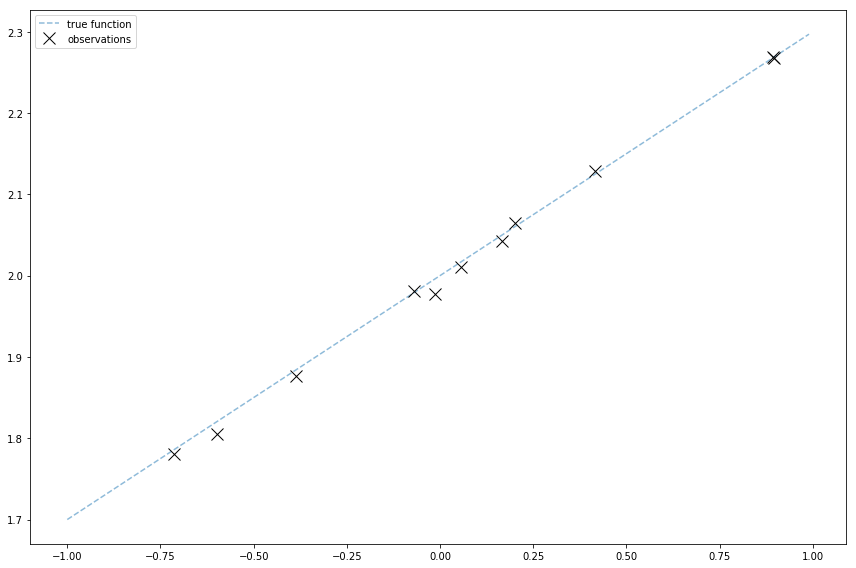

In [9]:
full_x = np.arange(-1, 1, 0.01)

plt.figure(figsize=(12, 8))
plt.plot(full_x, f2(full_x[:, None]), '--', alpha=0.5, label='true function')
plt.plot(x, f2(x) + noise, 'xk', markersize='12', label='observations')
plt.legend()
maybe_save_plot('2018-01-08-linear-sample-example')  # linear function with x's marking samples
plt.show()


The light blue line shows the true function. The black x's mark the sample observations.


## Other functions

The image at the top of this post is of observations I generated for a Gaussian Process demo.

Gaussian Processes are cool because they can fit a lot of functions. So I made and plotted
a funnier function that can show off Gaussian Processes.
I do it by using a linear combination of logistic sigmoids.

In [10]:
# I just use regular Python for this. I'm still learning numpy tricks :)
# This is holding some params I'll use, including the coefficient of the whole
# logistic sigmoid, and the weight and bias used within it.
f_params = [
    (-2, 5, -2),
    (-2, 2, 0),
    (3, 10, 1),
]

# Logistic sigmoid
def sig(x, w, b):
    return 1 / (1 + np.exp(-(w * x + b)))

# Linearly combine logistic sigmoids
def f3(x): return np.sum(
    ((c * sig(x, w, b)) for (c, w, b) in f_params)
)

# Like before, grab some uniformly distributed input locations
x = 2 * np.random.rand(11, 1) - 1

# Run the function and add noise
true_sigma_y = 0.01
noise = true_sigma_y * np.random.randn(x.shape[0], 1)
y = f3(x) + noise

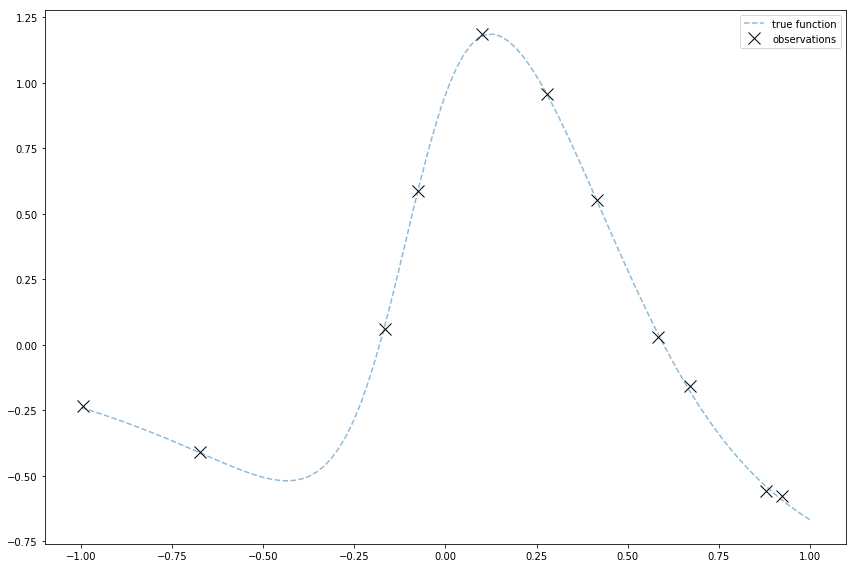

In [11]:
# For plotting the full function
full_x = np.linspace(-1, 1, 100)[:, None]

plt.figure(figsize=(12, 8))
plt.plot(full_x, f3(full_x), '--', alpha=0.5, label='true function')
plt.plot(x, y, 'xk', markersize='12', label='observations')
plt.legend()
maybe_save_plot('2018-01-08-sigmoid')
plt.show()


### [Next](2018-01-10-bayesian-linreg-plots.ipynb)

## See Also

 - Thanks to all of the code examples in [MLPR](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/)
 - Section 2.1 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) talks about the function and error.
